In [ ]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded35.csv')

In [ ]:
df = data[data['L_Botnet'] == 1]
df.head()
df = df.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
df.head()

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

In [ ]:
data = df.copy()

In [ ]:
np.set_printoptions(suppress=True)

dataNorm = data.values

from sklearn.preprocessing import MinMaxScaler

# Apply min-max normalization using MinMaxScaler
# data è un NP ARRAY adatto per le reti neurali (standard behaviour)
scaler = MinMaxScaler()
dataNorm = scaler.fit_transform(dataNorm)

In [ ]:
dataNorm

array([[0.0252823 , 1.        , 0.0000404 , ..., 0.0593653 , 0.        ,
        0.        ],
       [0.10673353, 1.        , 0.00004766, ..., 0.0310115 , 0.        ,
        0.        ],
       [0.05713197, 1.        , 0.0000404 , ..., 0.0443452 , 0.        ,
        0.        ],
       ...,
       [0.02880334, 1.        , 0.0000422 , ..., 0.05728291, 0.        ,
        0.        ],
       [0.10765423, 1.        , 0.00004401, ..., 0.03082969, 0.        ,
        0.        ],
       [0.04126987, 1.        , 0.00004401, ..., 0.05086092, 0.        ,
        0.        ]])

BASATO SU:



*   https://www.kaggle.com/code/samanemami/gan-on-tabular-data/notebook
*   https://github.com/mm32-star/Network-Data-Generation-Vanilla-GAN



# Architettura GAN

In [ ]:
# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

#### Versione iniziale



In [ ]:
class Gan():

    def __init__(self, data):


        self.data = data
        self.n_epochs = 200

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):

            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator

In [ ]:
model = Gan(data=dataNorm)

generator = model._generator()
descriminator = model._discriminator()

gan_model = model._GAN(generator=generator, discriminator=descriminator)

trained_model = model.train(generator=generator, discriminator=descriminator, gan=gan_model)

2973/2973 [==============================] - 4s 1ms/step
>1, cLoss=0.154, gLoss=0.232
2973/2973 [==============================] - 3s 1ms/step
>2, cLoss=0.108, gLoss=0.120
2973/2973 [==============================] - 3s 1ms/step
>3, cLoss=0.073, gLoss=0.056
2973/2973 [==============================] - 3s 1ms/step
>4, cLoss=0.047, gLoss=0.025
2973/2973 [==============================] - 3s 1ms/step
>5, cLoss=0.030, gLoss=0.011
2973/2973 [==============================] - 3s 1ms/step
>6, cLoss=0.019, gLoss=0.005
2973/2973 [==============================] - 3s 1ms/step
>7, cLoss=0.012, gLoss=0.002
2973/2973 [==============================] - 3s 1ms/step
>8, cLoss=0.008, gLoss=0.001
2973/2973 [==============================] - 3s 1ms/step
>9, cLoss=0.005, gLoss=0.000
2973/2973 [==============================] - 3s 1ms/step
>10, cLoss=0.004, gLoss=0.000
2973/2973 [==============================] - 3s 1ms/step
>11, cLoss=0.002, gLoss=0.000
2973/2973 [==============================] - 4s 1ms/

In [ ]:
noise = np.random.normal(0, 1, dataNorm.shape)
new_data = trained_model.predict(noise)

2973/2973 [==============================] - 4s 1ms/step


#### WGAN code ottimizzato da CHATGPT - RIFERIMENTO -

In [ ]:
class Wgan():
    def __init__(self, data, critic_lr, generator_lr, n_epochs, batch_size):
        self.data = data
        self.n_epochs = n_epochs
        self.critic_lr = critic_lr
        self.generator_lr = generator_lr
        self.batch_size = batch_size

    def _noise(self):
        noise = np.random.normal(0, 1, (self.batch_size, self.data.shape[1]))
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dense(self.data.shape[1], activation='sigmoid'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        critic_optimizer = tf.keras.optimizers.legacy.Adam(lr=self.critic_lr)
        model.compile(loss=wasserstein_loss, optimizer=critic_optimizer, metrics=['accuracy'])
        return model

    def _WGAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        generator_optimizer = tf.keras.optimizers.legacy.Adam(lr=self.generator_lr)

        model = tf.keras.Sequential(name="WGAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss=wasserstein_loss, optimizer=generator_optimizer)
        return model

    def train(self, generator, discriminator, gan):
        d_hist, g_hist = list(), list()

        for epoch in range(self.n_epochs):
            for _ in range(0, self.data.shape[0], self.batch_size):
                end_idx = min(_, self.data.shape[0])
                start_idx = end_idx - self.batch_size
                batch_data = self.data[start_idx:end_idx]

                generated_data = generator.predict(self._noise())
                labels = np.concatenate([np.ones(self.batch_size), np.zeros(self.batch_size)])
                X = np.concatenate([batch_data, generated_data])
                discriminator.trainable = True
                d_loss , _ = discriminator.train_on_batch(X, labels)

                noise = self._noise()
                g_loss = gan.train_on_batch(noise, np.ones(self.batch_size))

            print('>%d, cLoss=%.3f, gLoss=%.3f' % (epoch + 1, d_loss, g_loss))
        return generator



In [ ]:
gan_instance = Wgan(data=dataNorm, critic_lr=0.0001, generator_lr=0.0002, n_epochs=100, batch_size=32)
generator_model = gan_instance.train(generator=gan_instance._generator(),
                                     discriminator=gan_instance._discriminator(),
                                     gan=gan_instance._WGAN(gan_instance._generator(), gan_instance._discriminator()))


1/1 [==============================] - 1s 801ms/step


ValueError: ignored

#### PROVA WGAN da ottimizzare meglio - BASE -

In [ ]:
class Gan():
    def __init__(self, data, epochs, lr_d, lr_g, noise_dim):
        self.data = data
        self.n_epochs = epochs
        self.lr_discriminator = lr_d
        self.lr_generator = lr_g
        self.noise_dim = noise_dim

    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(self.data.shape[1], activation='sigmoid'))  # Use sigmoid activation to ensure [0, 1]
        print(model.summary())
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Critic_model")
        model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(1, activation=None))  # No activation for the last layer for the WGAN
        model.compile(loss=wasserstein_loss,
                      optimizer= tf.keras.optimizers.RMSprop(learning_rate=self.lr_discriminator),
                      metrics=['accuracy'])
        print(model.summary())
        return model

    def _WGAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="WGAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.lr_generator))
        return model

    def train(self, generator, discriminator, gan):
        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
          # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = -np.ones(2 * self.data.shape[0])  # Use -1 for real samples, 1 for generated samples
            labels[:self.data.shape[0]] = 1
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, labels)
          # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, -np.ones(self.data.shape[0]))  # Use -1 for the generator loss

            print('>%d, dLoss=%.3f, gLoss=%.3f' % (epoch + 1, d_loss[0], g_loss))
        return generator


#### WGAN modificata con batch_size e noise_dim

In [ ]:
class Gan():
    def __init__(self, data, epochs, lr_d, lr_g, noise_dim, batch_size):
        self.data = data
        self.n_epochs = epochs
        self.lr_discriminator = lr_d
        self.lr_generator = lr_g
        self.noise_dim = noise_dim
        self.batch_size = batch_size

    def _noise(self):
        noise = np.random.normal(0, 1, (self.batch_size, self.noise_dim))
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        #model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(self.data.shape[1], activation='sigmoid'))  # Use sigmoid activation to ensure [0, 1]
        print(model.summary())
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Critic_model")
        model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=self.data.shape[1]))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        #model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(1, activation=None))  # No activation for the last layer for the WGAN
        model.compile(loss=wasserstein_loss,
                      optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.lr_discriminator),
                      metrics=['accuracy'])
        print(model.summary())
        return model

    def _WGAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="WGAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.lr_generator))
        return model


    def train(self, generator, discriminator, gan):
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = -np.ones(2 * self.batch_size)  # Use -1 for real samples, 1 for generated samples
            labels[:self.batch_size] = 1
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, labels, batch_size=self.batch_size)  # Pass batch_size to training batch

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, -np.ones(self.batch_size))  # Use -1 for the generator loss

            print('>%d, dLoss=%.3f, gLoss=%.3f' % (epoch + 1, d_loss[0], g_loss))
        return generator




```
#  If the Wasserstein distance is decreasing over time,
and the generator is producing plausible samples,
the training is likely progressing well.
```



## Training

In [ ]:
lr_d = 0.00001 #@param
lr_g = 0.00003 #@param #maggiore del critic (tendenzialmente)
epochs = 500  #@param



batch_size = 64 #@param
noise_dim = 64 #@param

In [ ]:
gan_instance = Gan(dataNorm, epochs, lr_d, lr_g, noise_dim)
#gan_instance = Gan(dataNorm, epochs, lr_d, lr_g, noise_dim, batch_size)

# Create generator, discriminator, and GAN models
generator_model = gan_instance._generator()
discriminator_model = gan_instance._discriminator()
gan_model = gan_instance._WGAN(generator_model, discriminator_model)

# Train the GAN model
trained_generator = gan_instance.train(generator_model, discriminator_model, gan_model)


## Generazione dei dati

In [ ]:
np.random.seed(3) #per la ritestabilità/ripetibilità?
noise = np.random.normal(0, 1, dataNorm.shape)
new_data = trained_generator.predict(noise)

23/23 [==============================] - 0s 1ms/step


In [ ]:
dataNorm

array([[0.0252823 , 1.        , 0.0000404 , ..., 0.0593653 , 0.        ,
        0.        ],
       [0.10673353, 1.        , 0.00004766, ..., 0.0310115 , 0.        ,
        0.        ],
       [0.05713197, 1.        , 0.0000404 , ..., 0.0443452 , 0.        ,
        0.        ],
       ...,
       [0.02880334, 1.        , 0.0000422 , ..., 0.05728291, 0.        ,
        0.        ],
       [0.10765423, 1.        , 0.00004401, ..., 0.03082969, 0.        ,
        0.        ],
       [0.04126987, 1.        , 0.00004401, ..., 0.05086092, 0.        ,
        0.        ]])

In [ ]:
new_data

array([[0.89719355, 0.752115  , 0.14984901, ..., 0.55697155, 0.90482295,
        0.4352156 ],
       [0.78256613, 0.72447443, 0.1987266 , ..., 0.77859014, 0.9570363 ,
        0.24813369],
       [0.9161864 , 0.6081902 , 0.21232218, ..., 0.76347166, 0.92427367,
        0.21980059],
       ...,
       [0.80681866, 0.6604579 , 0.1459691 , ..., 0.78061825, 0.9181628 ,
        0.25648388],
       [0.707432  , 0.56734735, 0.15386862, ..., 0.68001866, 0.87049466,
        0.31197768],
       [0.7744191 , 0.61112314, 0.15635179, ..., 0.7159661 , 0.90960306,
        0.33607718]], dtype=float32)

# Valutazione

In [ ]:
from scipy.stats import wasserstein_distance

real_data = dataNorm
generated_data = new_data

# Flatten the arrays for 1D distribution
real_flat = real_data.flatten()
generated_flat = generated_data.flatten()

# Compute Wasserstein distance
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance final:', w_distance) #0.2382

Wasserstein Distance final: 0.39641721544130437




```
# 0 = Flow Duration
# 1 = BwdPacketLengthStd
# 2 = PacketLengthVariance
# 5 = PacketLengthStd
# 6 = FlowIATMax
# 26 = FlowIATMean
```



In [ ]:
from scipy.stats import ks_2samp

# Assuming real_data and generated_data are NumPy arrays
# Both arrays should have the same number of observations (rows)
real_data = dataNorm
generated_data = new_data

# Choose the column you want to check
# 0 = FlowDuration
column_to_check = 0

# Perform the KS test for the selected column
ks_statistic, ks_p_value = ks_2samp(real_data[:, column_to_check], generated_data[:, column_to_check])

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Interpret the results
alpha = 0.1  # significance level
if ks_p_value > alpha:
    print("The distributions are similar (fail to reject the null hypothesis)")
else:
    print("The distributions are different (reject the null hypothesis)")

#0.186

KS Statistic: 0.998641304347826
P-value: 0.0
The distributions are different (reject the null hypothesis)


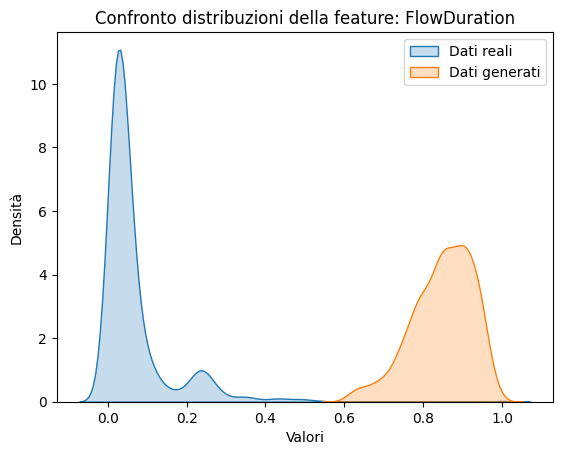

In [ ]:
# Choose the column you want to compare
column_to_compare = 0


# Extract the selected column for each array
real_column = dataNorm[:, column_to_compare]
generated_column = new_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {data.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend()
#salva in Drive
#images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf'
#plt.savefig(f"{images_dir}/distributionFeatureFlowDuration_genWGAN_t2.pdf", dpi=200, format='pdf') ###!!!!!!!!!!!!!! CAMBIARE TENTATIVI CON N°
plt.show()



## Valuto con dataframe

In [ ]:
real_data = pd.DataFrame(dataNorm, columns=(data.columns).to_numpy())
gen_data = pd.DataFrame(new_data, columns=(data.columns).to_numpy())

In [ ]:
mse_value = tf.keras.losses.mean_squared_error(real_data['FlowDuration'], gen_data['FlowDuration'])
print(f'Mean Squared Error: {mse_value}')

#deve essere basso
#0.03688

Mean Squared Error: 0.6243324875831604


Text(0.5, 1.0, 'synthetic Data')

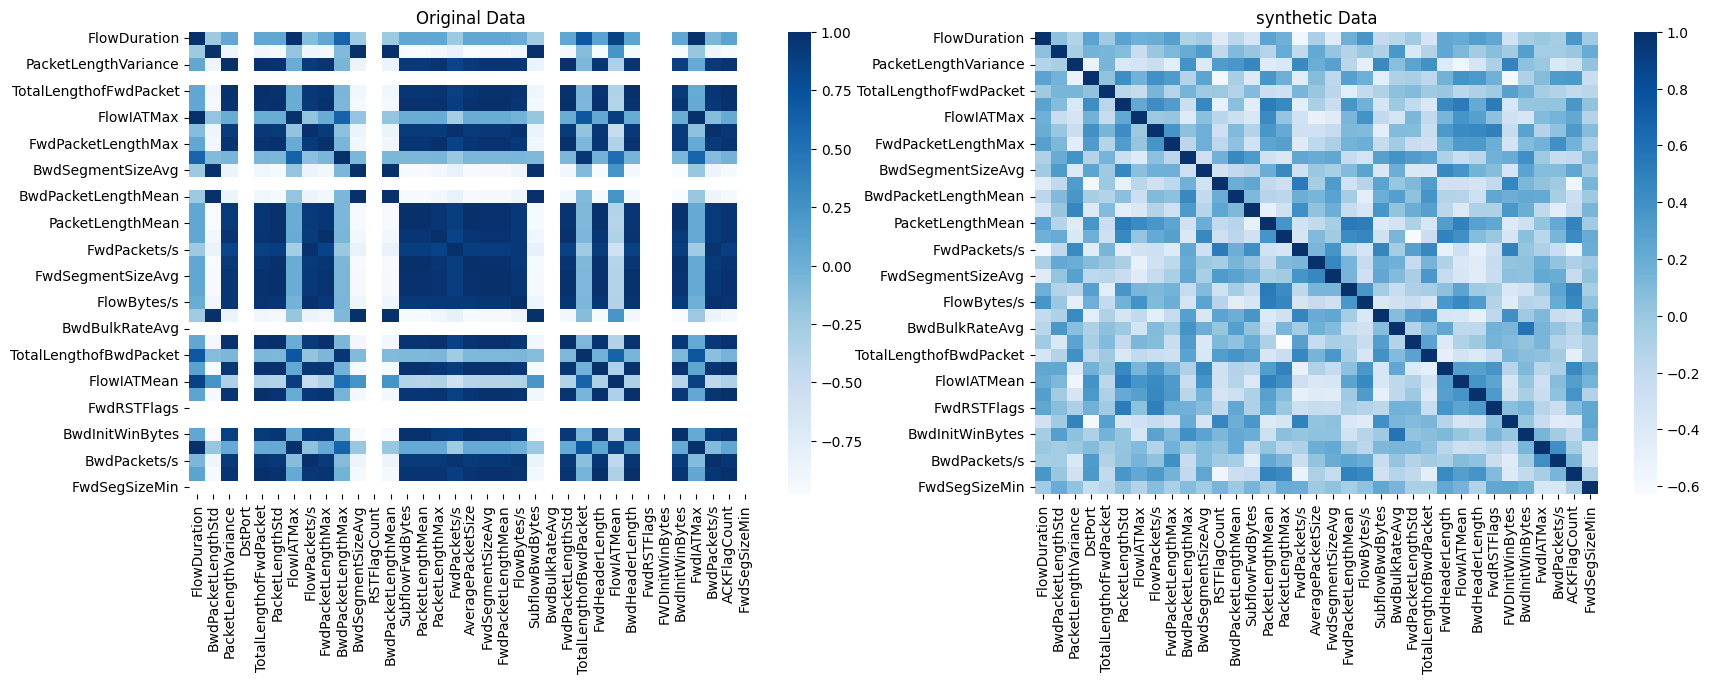

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(real_data.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_data.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

Text(0.5, 1.0, 'synthetic Data')

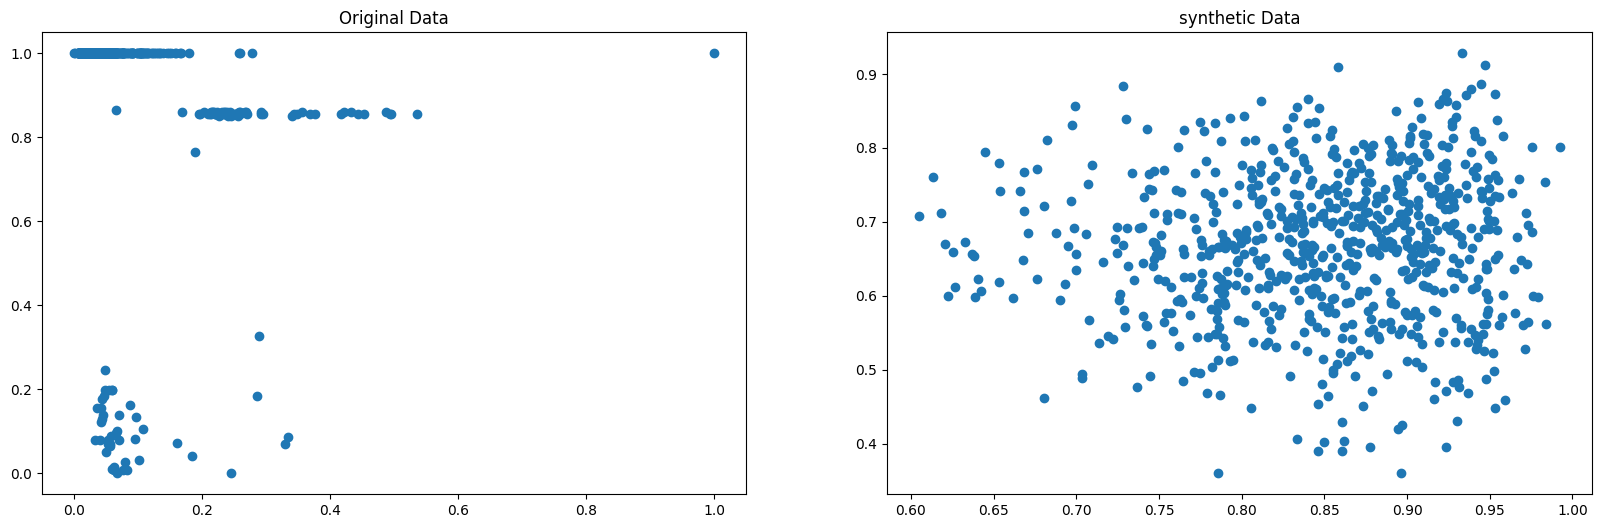

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(real_data.iloc[:, 0], real_data.iloc[:, 1])
ax[1].scatter(gen_data.iloc[:, 0], gen_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

In [ ]:
real_data.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.02528229604309313594,1.00000000000000000000,0.00004039507880797797,0.00000000000000000000,0.00000000000000000000,0.00137933295035008383,0.02500328930951721540,0.09114660091098431005,0.00000000000000000000,0.00000000000000000000,...,0.00000000000000000000,0.09159379534288929203,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.02516197920132608179,0.05936530079449003211,0.00000000000000000000,0.00000000000000000000
1,0.10673352977015682086,1.00000000000000000000,0.00004766076024524844,0.00000000000000000000,0.00001925632088733129,0.00161480637434856938,0.10745380221495297313,0.04761354573079354391,0.00017266683933350561,0.00000000000000000000,...,0.00000000000000000000,0.16750378014594813347,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.10693198385955147989,0.03101149616057843200,0.00000000000000000000,0.00000000000000000000
2,0.05713197198280750566,1.00000000000000000000,0.00004039507880797797,0.00000000000000000000,0.00000000000000000000,0.00137933295035008383,0.05741697707162225772,0.06808547253806257471,0.00000000000000000000,0.00000000000000000000,...,0.00000000000000000000,0.12127669032109925085,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.05749883544365060051,0.04434520340373958314,0.00000000000000000000,0.00000000000000000000
3,0.02965903747972260807,1.00000000000000000000,0.00004219636233096795,0.00000000000000000000,0.00000481408022183277,0.00143803765154268057,0.03002118769026954070,0.08720267870305518920,0.00004316670983337684,0.00000000000000000000,...,0.00000000000000000000,0.09567278053118936920,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.02979146879291465211,0.05679655850631144115,0.00000000000000000000,0.00000000000000000000
4,0.01254514695721981044,1.00000000000000000000,0.00004219636233096795,0.00000000000000000000,0.00000481408022183277,0.00143803765154268057,0.01294702472502129442,0.10468657967506994622,0.00004316670983337684,0.00000000000000000000,...,0.00000000000000000000,0.07972317350819906057,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.01257115893018105612,0.06818411470578401856,0.00000000000000000000,0.00000000000000000000


In [ ]:
gen_data.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.89719355106353759766,0.75211501121520996094,0.14984901249408721924,0.90686964988708496094,0.34308585524559020996,0.92257505655288696289,0.74425536394119262695,0.86371541023254394531,0.79595929384231567383,0.36453533172607421875,...,0.78396284580230712891,0.69478613138198852539,0.78361904621124267578,0.93981802463531494141,0.18403199315071105957,0.47330501675605773926,0.56532990932464599609,0.55697154998779296875,0.90482294559478759766,0.43521559238433837891
1,0.78256613016128540039,0.72447443008422851562,0.19872659444808959961,0.82419896125793457031,0.11115319281816482544,0.66860538721084594727,0.75495028495788574219,0.60284215211868286133,0.87604677677154541016,0.12168723344802856445,...,0.47632920742034912109,0.66919028759002685547,0.71116560697555541992,0.41885253787040710449,0.07141073793172836304,0.32891643047332763672,0.75098431110382080078,0.77859014272689819336,0.95703631639480590820,0.24813368916511535645
2,0.91618639230728149414,0.60819017887115478516,0.21232217550277709961,0.94017142057418823242,0.28679373860359191895,0.84458768367767333984,0.93783062696456909180,0.88206452131271362305,0.84792613983154296875,0.05172739550471305847,...,0.62597268819808959961,0.72869408130645751953,0.66622996330261230469,0.48568192124366760254,0.05109243094921112061,0.24405875802040100098,0.85284435749053955078,0.76347166299819946289,0.92427366971969604492,0.21980059146881103516
3,0.76384961605072021484,0.59150302410125732422,0.09471574425697326660,0.90252822637557983398,0.35828596353530883789,0.89346736669540405273,0.68994235992431640625,0.88828575611114501953,0.82972258329391479492,0.17306479811668395996,...,0.72296100854873657227,0.81487756967544555664,0.74575918912887573242,0.64440453052520751953,0.09432330727577209473,0.28984016180038452148,0.58003926277160644531,0.79571115970611572266,0.93838393688201904297,0.39114403724670410156
4,0.87835496664047241211,0.79188561439514160156,0.29148283600807189941,0.86791056394577026367,0.36385294795036315918,0.62374734878540039062,0.82948619127273559570,0.75911432504653930664,0.72181856632232666016,0.18458698689937591553,...,0.69311064481735229492,0.55341345071792602539,0.90504121780395507812,0.59202408790588378906,0.07130900770425796509,0.33488455414772033691,0.76780581474304199219,0.62945878505706787109,0.94307565689086914062,0.41504827141761779785


In [ ]:
# Assuming real_data and generated_data are your Pandas DataFrames
real = real_data['FlowDuration'].to_numpy()
gen = gen_data['FlowDuration'].to_numpy()

# Calculate Wasserstein distance for the selected feature
w_dist_feature = wasserstein_distance(real, gen)

print("Wasserstein Distance for FlowDuration feature:", w_dist_feature)

Wasserstein Distance for FlowDuration feature: 0.7817185698374165
